In [1]:
import os
import re
import cv2
import json
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.efficientnet import EfficientNet_B0_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# //TODO::WTF::

IMAGES_DIR = "/kaggle/input/flickr8k/Images"
CAPTIONS_FILE = "/kaggle/input/flickr8k/captions.txt"

BATCH_SIZE = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def load_captions(captions_file):
    captions_dict = {}
    with open(captions_file, 'r') as file:
        for line in file:
            tokens = line.strip().split(",") 
            if len(tokens) == 2:
                image_id, caption = tokens
                if image_id not in captions_dict:
                    captions_dict[image_id] = []
                captions_dict[image_id].append(caption)
    return captions_dict

def display_images_with_captions(images_dir, captions_dict, num_images=3, image_size=(224, 224)):
    images = list(captions_dict.keys())

    if len(images) < num_images:
        raise ValueError(f"Requested {num_images} images, but only {len(images)} available.")
    
    selected_images = random.sample(images, num_images)
    plt.figure(figsize=(10 * num_images, 10))
    
    for i, image in enumerate(selected_images):
        img_path = os.path.join(images_dir, image)
        img = Image.open(img_path)
        
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(img)
        plt.axis('off')
        
        captions = "\n".join(captions_dict[image]) 
        plt.title(captions, fontsize=10, loc='center', wrap=True)
    
    plt.tight_layout()
    plt.show()

# def plot_training_losses(train_losses, val_losses):
#     plt.figure(figsize=(10, 6))
#     plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
#     plt.plot(range(1, len(val_losses) + 1), val_losses, marker='x', label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Training and Validation Loss Over Epochs')
#     plt.grid(True)
#     plt.legend()
#     plt.show()


def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

In [4]:
def split_dataset(captions_dict, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

    flattened_captions = []
    for image_id, captions in captions_dict.items():
        for caption in captions:
            flattened_captions.append((image_id, caption))

    random.seed(random_seed)
    random.shuffle(flattened_captions)

    total_samples = len(flattened_captions)
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_samples = flattened_captions[:train_end]
    val_samples = flattened_captions[train_end:val_end]
    test_samples = flattened_captions[val_end:]

    train_captions = {image_id: [] for image_id, _ in train_samples}
    for image_id, caption in train_samples:
        train_captions[image_id].append(caption)

    val_captions = {image_id: [] for image_id, _ in val_samples}
    for image_id, caption in val_samples:
        val_captions[image_id].append(caption)

    test_captions = {image_id: [] for image_id, _ in test_samples}
    for image_id, caption in test_samples:
        test_captions[image_id].append(caption)

    return train_captions, val_captions, test_captions

def save_captions_to_json(captions, filepath):
    with open(filepath, 'w') as file:
        json.dump(captions, file, ensure_ascii=False, indent=4)

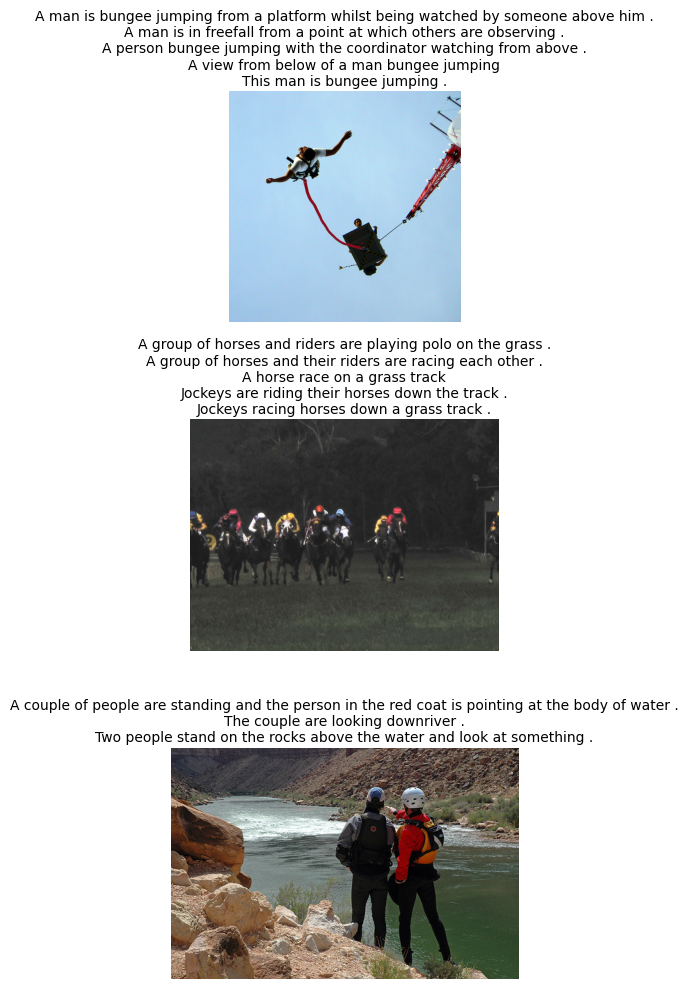

In [5]:
captions_dict = load_captions(CAPTIONS_FILE)
display_images_with_captions(IMAGES_DIR, captions_dict)

In [6]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)      # Remove numbers
    return text.strip()

def build_tokenizer(captions_dict):
    special_tokens = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
    word_to_index = defaultdict(lambda: special_tokens["<unk>"], special_tokens.copy())
    # Tokenize captions and build vocabulary
    vocab = set()
    for captions in captions_dict.values():
        for caption in captions:
            preprocessed_caption = preprocess_text(caption)
            vocab.update(preprocessed_caption.split())
    # Add vocabulary words to the tokenizer
    for idx, word in enumerate(sorted(vocab), start=len(special_tokens)):
        word_to_index[word] = idx
    return dict(word_to_index)

def save_tokenizer_to_json(tokenizer, filepath):
    with open(filepath, 'w') as file:
        json.dump(tokenizer, file, ensure_ascii=False, indent=4)

def caption_tokenizer(caption, word_to_index, max_length=50): # //TODO::WTF::
    tokens = ["<sos>"] + caption.lower().split() + ["<eos>"]
    token_ids = [word_to_index.get(word, word_to_index["<unk>"]) for word in tokens]
    token_ids = token_ids[:max_length]
    token_ids += [word_to_index["<pad>"]] * (max_length - len(token_ids))
    return torch.tensor(token_ids)

In [7]:
word_to_index_tokenizer = build_tokenizer(captions_dict)

TOKENIZER_FILE = "tokenizer.json"
save_tokenizer_to_json(word_to_index_tokenizer, TOKENIZER_FILE)

print(f"Word to Index Tokenizer saved to {TOKENIZER_FILE}. Total tokens: {len(word_to_index_tokenizer)}")

Word to Index Tokenizer saved to tokenizer.json. Total tokens: 8478


In [8]:
train_captions, val_captions, test_captions = split_dataset(captions_dict)

save_captions_to_json(train_captions, "train_captions.json")
save_captions_to_json(val_captions, "val_captions.json")
save_captions_to_json(test_captions, "test_captions.json")

print("Dataset split complete:")
print(f"Training: {len(train_captions)} images")
print(f"Validation: {len(val_captions)} images")
print(f"Test: {len(test_captions)} images")

Dataset split complete:
Training: 8084 images
Validation: 3166 images
Test: 3119 images


In [12]:
class FlickrDataset(Dataset):
    def __init__(self, captions_file, images_dir, transform=None, tokenizer=None, max_seq_length=50):
        with open(captions_file, 'r') as file:
            self.captions_dict = json.load(file)

        self.images_dir = images_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

        self.image_caption_pairs = []
        for image_id, captions in self.captions_dict.items():
            image_path = os.path.join(images_dir, image_id)
            if os.path.exists(image_path):
                for caption in captions:
                    self.image_caption_pairs.append((image_id, caption))
        
        random.shuffle(self.image_caption_pairs)
    
    def __len__(self):
        return len(self.image_caption_pairs)

    def __getitem__(self, idx):
        image_id, caption = self.image_caption_pairs[idx]
        image_path = os.path.join(self.images_dir, image_id)

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        if self.tokenizer:
            caption = self.tokenizer(caption)

        return image, caption

def create_dataloaders(images_dir, train_captions_file, val_captions_file, test_captions_file, batch_size, tokenizer):
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.25),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    train_dataset = FlickrDataset(train_captions_file, images_dir, transform=transform_train, tokenizer=tokenizer)
    val_dataset = FlickrDataset(val_captions_file, images_dir, transform=val_transform, tokenizer=tokenizer)
    test_dataset = FlickrDataset(test_captions_file, images_dir, transform=val_transform, tokenizer=tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

In [13]:
with open(TOKENIZER_FILE, "r") as file:
    word_to_index = json.load(file)

train_loader, val_loader, test_loader = create_dataloaders(
    IMAGES_DIR,
    "train_captions.json",
    "val_captions.json",
    "test_captions.json",
    BATCH_SIZE,
    lambda caption: caption_tokenizer(caption, word_to_index)
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Testing batches: {len(test_loader)}")

Training batches: 476
Validation batches: 60
Testing batches: 60


In [14]:
PAD_IDX = word_to_index_tokenizer["<pad>"]

In [15]:
class CustomTokenizer:
    def __init__(self, captions_dict, max_length=50):
        self.max_length = max_length
        self.special_tokens = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
        self.word2idx = self.build_vocab(captions_dict)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}  # Build idx2word

    def build_vocab(self, captions_dict):
        vocab = set()
        for captions in captions_dict.values():
            for caption in captions:
                caption = caption.lower().strip()
                vocab.update(caption.split())
        
        word2idx = defaultdict(lambda: self.special_tokens["<unk>"], self.special_tokens.copy())
        for idx, word in enumerate(sorted(vocab), start=len(self.special_tokens)):
            word2idx[word] = idx
        return dict(word2idx)
    
    def encode(self, caption):
        tokens = ["<sos>"] + caption.lower().split() + ["<eos>"]
        token_ids = [self.word2idx.get(word, self.special_tokens["<unk>"]) for word in tokens]
        
        if len(token_ids) > self.max_length:
            token_ids = token_ids[:self.max_length]
        else:
            token_ids += [self.special_tokens["<pad>"]] * (self.max_length - len(token_ids))
            
        attention_mask = [False if token != self.special_tokens["<pad>"] else True for token in token_ids]
        return torch.tensor(token_ids), torch.tensor(attention_mask)

    def decode(self, token_ids):
        caption = []
        for idx in token_ids:
            idx = int(idx)  # Ensure it's an integer
            if idx == self.special_tokens["<eos>"]:  # Stop decoding at <eos>
                break
            if idx not in self.special_tokens.values():  # Skip special tokens
                caption.append(self.idx2word[idx])
        return " ".join(caption).strip()

In [16]:
tokenizer = CustomTokenizer(captions_dict, max_length=10)
caption = "A dog running in the park."
encoded_caption, attention_mask = tokenizer.encode(caption)
decoded_caption = tokenizer.decode(encoded_caption)

print("Encoded Caption:", encoded_caption)
print("Attention Mask:", attention_mask)
print("Decoded Caption:", decoded_caption)

Encoded Caption: tensor([   1,   85, 2240, 6265, 3792, 7655,    3,    2,    0,    0])
Attention Mask: tensor([False, False, False, False, False, False, False, False,  True,  True])
Decoded Caption: a dog running in the


In [17]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        efficient_net = models.efficientnet_b0(pretrained=True)
        self.features = efficient_net.features  # Extract only feature layers
        self.pooling = efficient_net.avgpool  # Global average pooling layer
        for param in self.features.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(efficient_net.classifier[1].in_features, embed_size)
        self.relu = nn.ReLU()

    def forward(self, images): # Extract image features
        features = self.features(images)
        features = self.pooling(features)
        features = features.flatten(start_dim=1)  # Flatten for FC layer
        features = self.fc(features)  # Pass through FC layer
        features = self.relu(features)
        return features

class DecoderTransformer(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, max_seq_length):
        super(DecoderTransformer, self).__init__()
        self.embed_size = embed_size
        self.vocab_size = vocab_size
        self.max_seq_length = max_seq_length
        # Embedding layers
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_embedding = nn.Parameter(torch.zeros(1, max_seq_length, embed_size))
        # Transformer decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=8, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        # Final linear layer
        self.fc_out = nn.Linear(embed_size, vocab_size)

    def forward(self, features, captions, tgt_mask):
        # Add positional embeddings to captions
        captions_embedding = self.word_embedding(captions) + self.positional_embedding[:, :captions.size(1), :]
        # Decode features and captions
        outputs = self.transformer_decoder(tgt=captions_embedding, memory=features.unsqueeze(1), tgt_mask=tgt_mask)
        # Generate vocabulary logits
        outputs = self.fc_out(outputs)
        return outputs

class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, max_seq_length):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderTransformer(embed_size, vocab_size, num_layers, max_seq_length)

    def forward(self, images, captions, tgt_mask):
        features = self.encoder(images)  # Extract image features
        outputs = self.decoder(features, captions, tgt_mask)  # Decode captions
        return outputs

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model = model.to(device)
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, captions in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            images, captions = images.to(device), captions.to(device)
            optimizer.zero_grad()
            # Generate masks for the captions
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(captions.size(1)).to(device)
            # Forward pass
            outputs = model(images, captions, tgt_mask)
            loss = criterion(outputs.view(-1, outputs.size(-1)), captions.view(-1))
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, captions in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                images, captions = images.to(device), captions.to(device)
                tgt_mask = nn.Transformer.generate_square_subsequent_mask(captions.size(1)).to(device)
                outputs = model(images, captions, tgt_mask)
                loss = criterion(outputs.view(-1, outputs.size(-1)), captions.view(-1))
                val_loss += loss.item()
                
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")
    return train_losses, val_losses

In [26]:
# # Save model
# torch.save(model.state_dict(), "image_captioning_model.pth")

# # Load model
# model.load_state_dict(torch.load("image_captioning_model.pth"))

In [23]:
# Hyperparameters
EMBED_SIZE = 256
NUM_LAYERS = 6
MAX_SEQ_LENGTH = 50
VOCAB_SIZE = len(word_to_index_tokenizer)  # Vocabulary size
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4

# Initialize the model
model = ImageCaptioningModel(
    embed_size=EMBED_SIZE,
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    max_seq_length=MAX_SEQ_LENGTH
)

# Loss function (ignores padding tokens)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 87.9MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_l

Validation Epoch 1/10: 100%|██████████| 60/60 [00:10<00:00,  5.86it/s]


Epoch 1/10, Train Loss: 1.8355565600785888, Val Loss: 0.6844573110342026


Validation Epoch 2/10: 100%|██████████| 60/60 [00:10<00:00,  5.87it/s]


Epoch 2/10, Train Loss: 0.5186406255018812, Val Loss: 0.3724543844660123


Validation Epoch 3/10: 100%|██████████| 60/60 [00:10<00:00,  5.59it/s]


Epoch 3/10, Train Loss: 0.30361628307013955, Val Loss: 0.2559573454161485


Validation Epoch 4/10: 100%|██████████| 60/60 [00:10<00:00,  5.92it/s]


Epoch 4/10, Train Loss: 0.20582493385221778, Val Loss: 0.19668615410725276


Validation Epoch 5/10: 100%|██████████| 60/60 [00:10<00:00,  5.82it/s]


Epoch 5/10, Train Loss: 0.14894530305466733, Val Loss: 0.15960065176089605


Validation Epoch 6/10: 100%|██████████| 60/60 [00:10<00:00,  5.80it/s]


Epoch 6/10, Train Loss: 0.11207022496006068, Val Loss: 0.1356184261540572


Validation Epoch 7/10: 100%|██████████| 60/60 [00:10<00:00,  5.63it/s]


Epoch 7/10, Train Loss: 0.08566735737698794, Val Loss: 0.11748918735732634


Validation Epoch 8/10: 100%|██████████| 60/60 [00:10<00:00,  5.68it/s]


Epoch 8/10, Train Loss: 0.06610210846812159, Val Loss: 0.1057807782664895


Validation Epoch 9/10: 100%|██████████| 60/60 [00:10<00:00,  5.89it/s]


Epoch 9/10, Train Loss: 0.05107987135797426, Val Loss: 0.09657493916650613


Validation Epoch 10/10: 100%|██████████| 60/60 [00:10<00:00,  5.56it/s]


Epoch 10/10, Train Loss: 0.03926792644559085, Val Loss: 0.09113851462801298


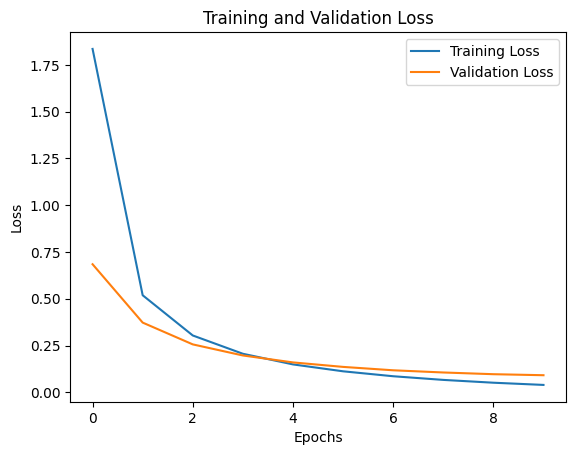

Model saved as 'image_captioning_model.pth'


In [24]:
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=device
)
plot_losses(train_losses, val_losses)
torch.save(model.state_dict(), "image_captioning_model.pth")
print("Model saved as 'image_captioning_model.pth'")

In [43]:
def generate_caption(model, tokenizer, image, device, max_seq_length=20):
    model.eval()
    with torch.no_grad():
        image = image.to(device).unsqueeze(0)  # Ensure image is a tensor and on the correct device
        features = model.encoder(image)
        caption = [tokenizer.special_tokens["<sos>"]]
        for _ in range(max_seq_length):
            tgt = torch.tensor(caption).unsqueeze(0).to(device)  # Target tokens as input
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(1)).to(device)
            outputs = model.decoder(features, tgt, tgt_mask)
            next_token = outputs.argmax(dim=-1)[:, -1].item()  # Get the next token
            caption.append(next_token)
            if next_token == tokenizer.special_tokens["<eos>"]:  # Stop if <eos> is reached
                break
        return tokenizer.decode(caption)

def visualize_results(model, dataloader, tokenizer, num_images=5):
    model = model.to(device)
    for images, _ in dataloader:
        images = images[:num_images].to(device)
        captions = [generate_caption(model, tokenizer, image) for image in images]

        plt.figure(figsize=(5, num_images * 5))
        for i in range(num_images):
            ax = plt.subplot(num_images, 1, i + 1)
            ax.imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Unnormalize the image
            ax.axis("off")
            ax.set_title(captions[i], fontsize=12, wrap=True)

        plt.tight_layout()
        plt.show()
        break

In [45]:
visualize_results(model, test_loader, tokenizer, num_images=5) 

AttributeError: 'dict' object has no attribute 'special_tokens'